In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from glob import glob
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
#import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
#from keras.layers.normalization import BatchNormalization
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
base_skin_dir = os.path.join('..', 'datasets/ham10000_2')
print(base_skin_dir)
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
# nicer labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

../datasets/ham10000_2


In [3]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ../datasets/ham10000_2/HAM10000_images_part_1/...   
1  ../datasets/ham10000_2/HAM10000_images_part_1/...   
2  ../datasets/ham10000_2/HAM10000_images_part_1/...   
3  ../datasets/ham10000_2/HAM10000_images_part_1/...   
4  ../datasets/ham10000_2/HAM10000_images_part_2/...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [4]:
# Count the number of unique scans using the 'image_id' column
num_scans = skin_df['image_id'].nunique()

print(f"Number of scans: {num_scans}")

Number of scans: 10015


In [5]:
# Count the number of unique patients using the 'lesion_id' column
num_unique_patients = skin_df['lesion_id'].nunique()

print(f"Number of unique patients: {num_unique_patients}")

Number of unique patients: 7470


In [6]:
skin_df.shape

(10015, 10)

# Data Cleaning

In [7]:
# data cleaning
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [8]:
# fill null with mean
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [10]:
# used for 3rd hierarchy visualizations
orig_skin_df = skin_df.copy()

# EDA

<Axes: >

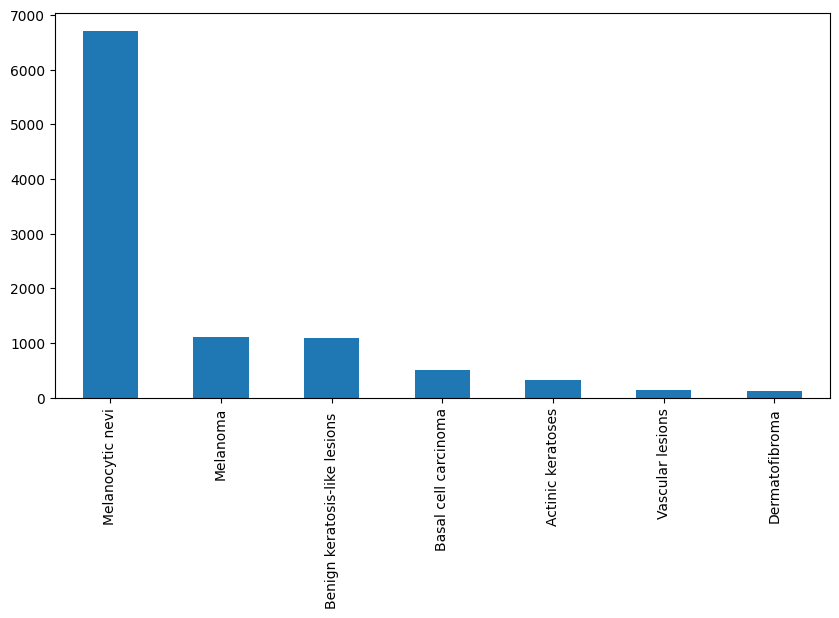

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: >

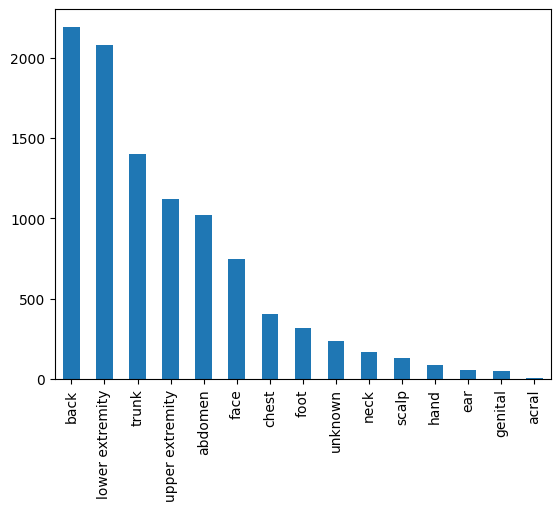

In [12]:
skin_df['localization'].value_counts().plot(kind='bar')

<Axes: >

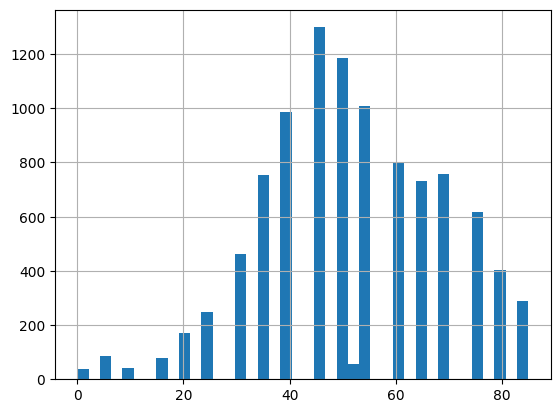

In [13]:
skin_df['age'].hist(bins=40)

<Axes: >

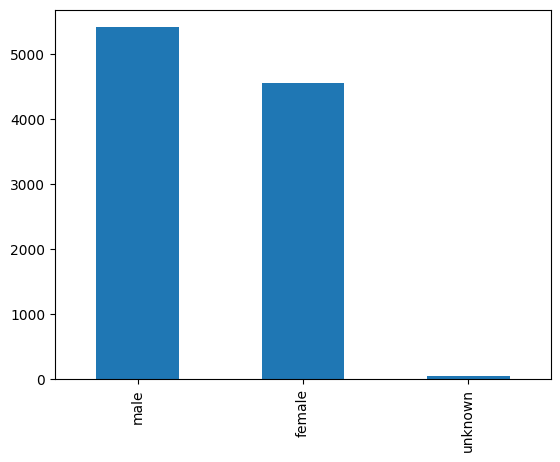

In [14]:
skin_df['sex'].value_counts().plot(kind='bar')

# Loading Images

The images have a dimension of 450 x 600 x 3. This is too large for CNN models. We will resize them to 100 x 75 x 3.

In [15]:
# minimize dataset
#skin_df = skin_df.sample(frac=0.1).reset_index(drop=True)

# resizing all images
#skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x)))

# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

Original image size: (600, 450)


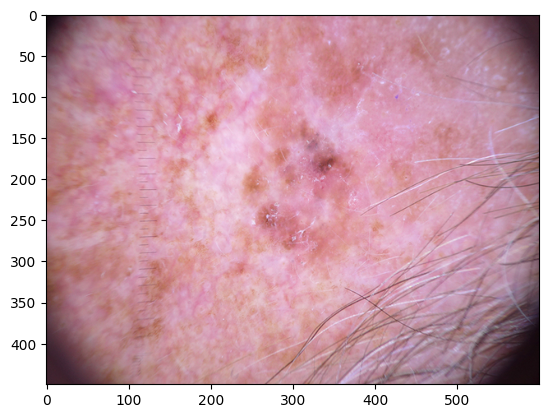

In [16]:
# get image
img_id = 3
img = Image.open(skin_df['path'][img_id])
print(f"Original image size: {img.size}")
plt.imshow(img)

Resized image size: (100, 75)


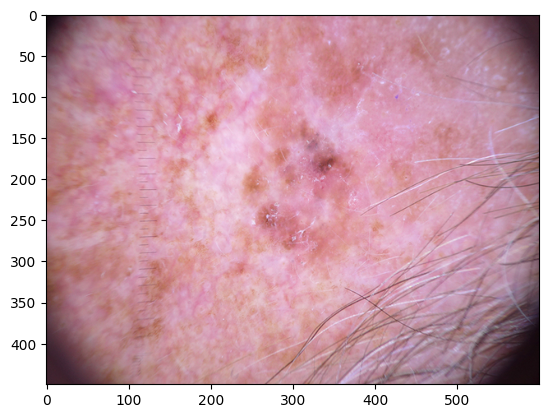

In [17]:
# resize 
mod_img = img.resize((100,75))
print(f"Resized image size: {mod_img.size}")
plt.imshow(img)

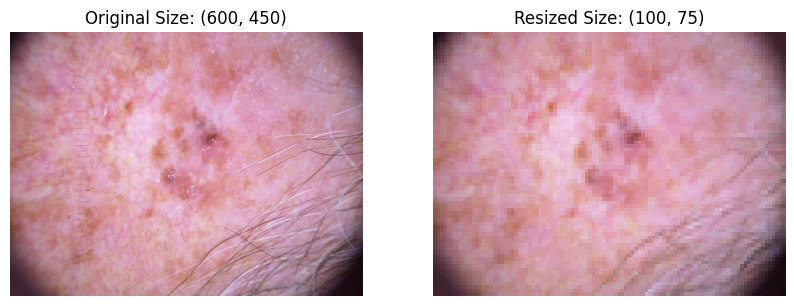

In [18]:
# Resize the image
resized_img = img.resize((100, 75))

# Plot both original and resized images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display original image
axes[0].imshow(img)
axes[0].set_title(f'Original Size: {img.size}')
axes[0].axis('off')  # Hide axes

# Display resized image
axes[1].imshow(resized_img)
axes[1].set_title(f'Resized Size: {resized_img.size}')
axes[1].axis('off')  # Hide axes

# Save the figure
#plt.savefig('image_comparison.png', bbox_inches='tight')

# Show the images
plt.show()

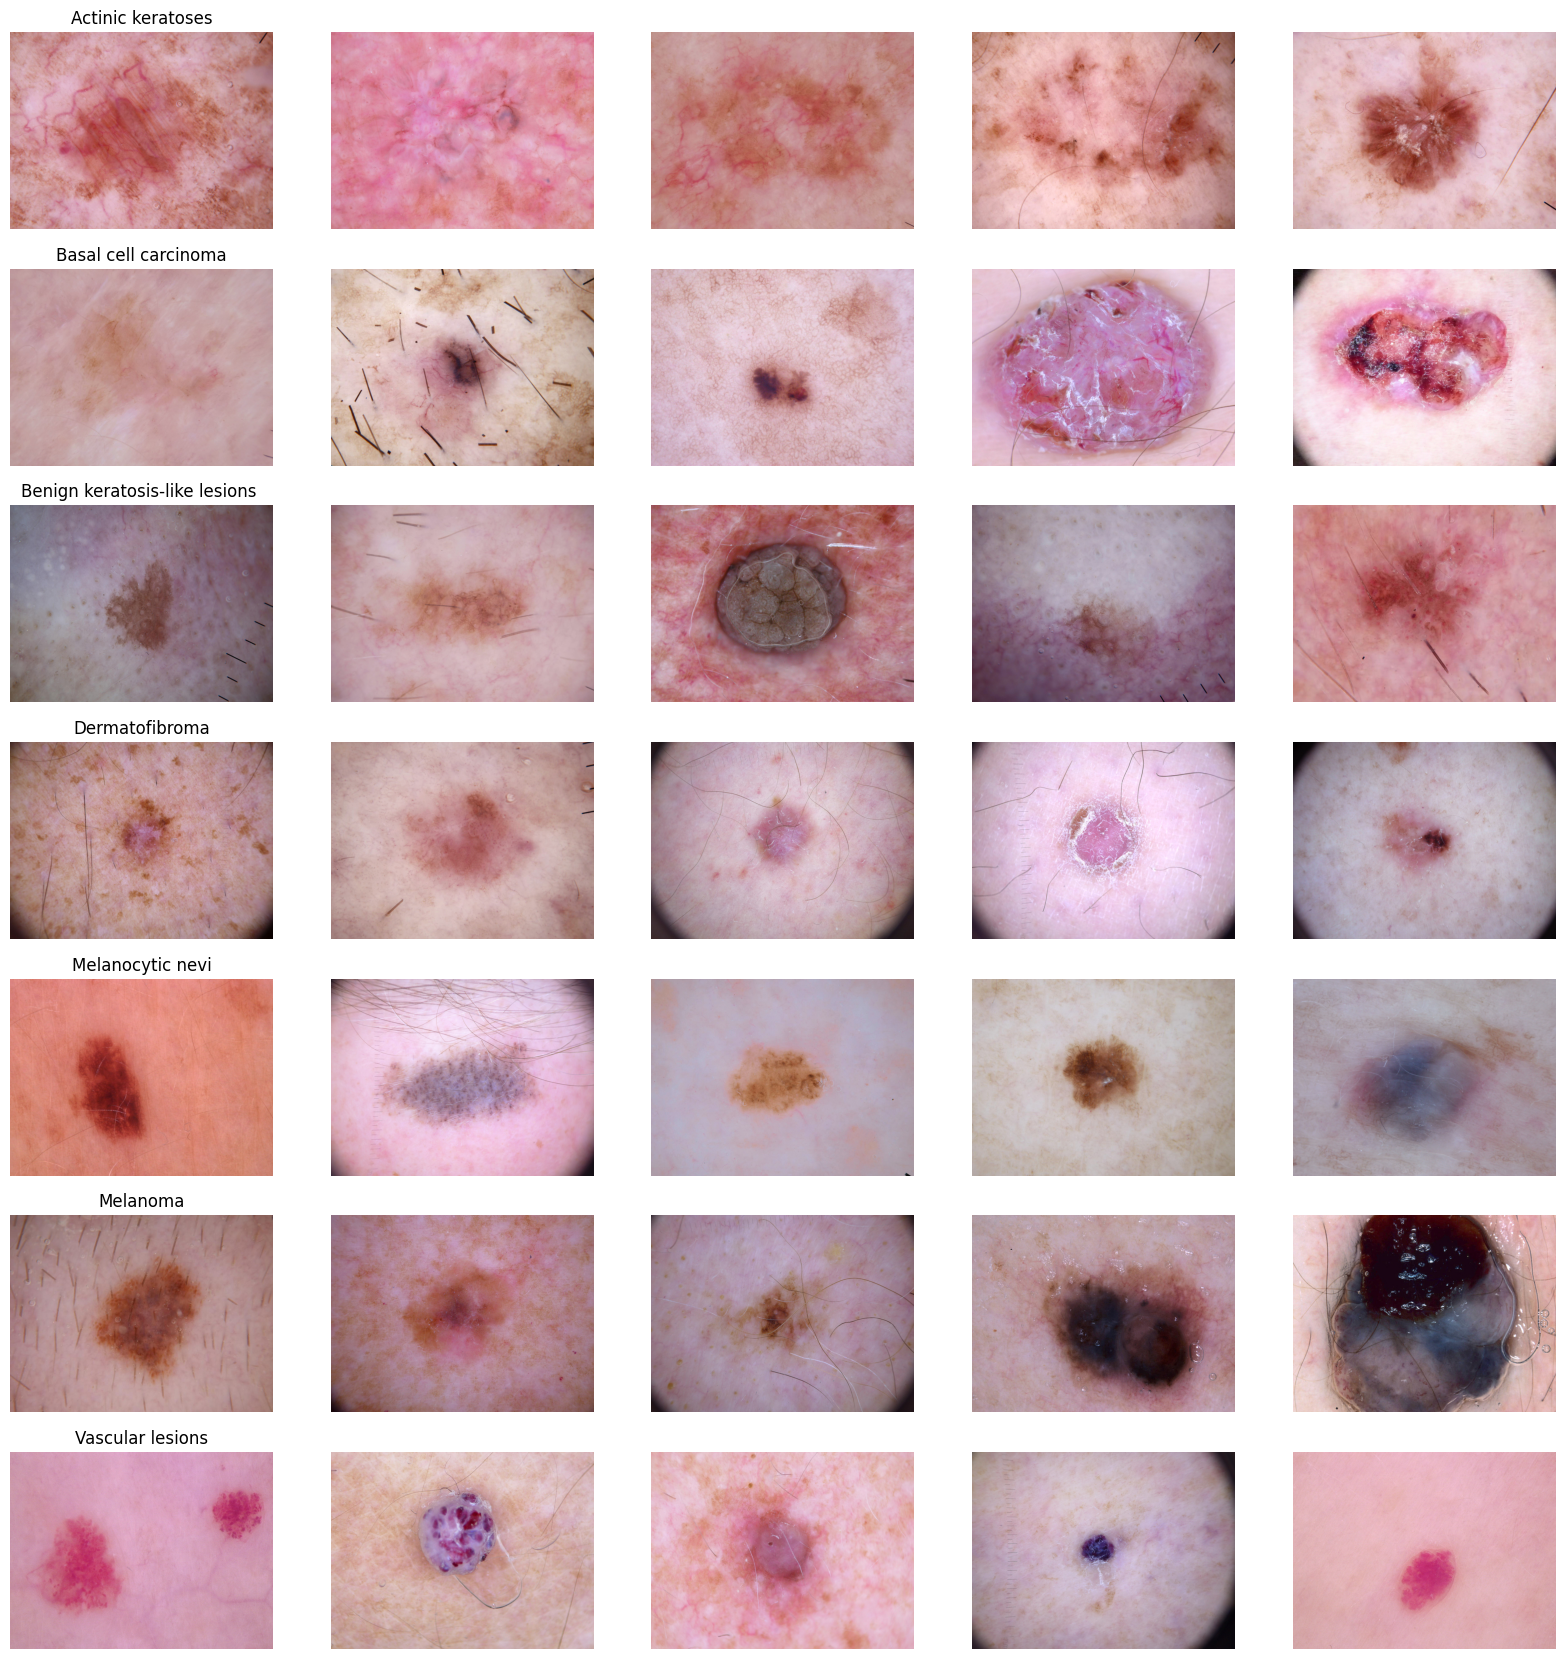

In [19]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# Hierarchy #2 (Skin Cancer vs. Non-Cancerous Skin Disease)

In [20]:
cancerous_labels = ['akiec', 'bcc', 'mel']  # Cancerous classes
non_cancerous_labels = ['bkl', 'df', 'nv', 'vasc']  # Non-cancerous classes

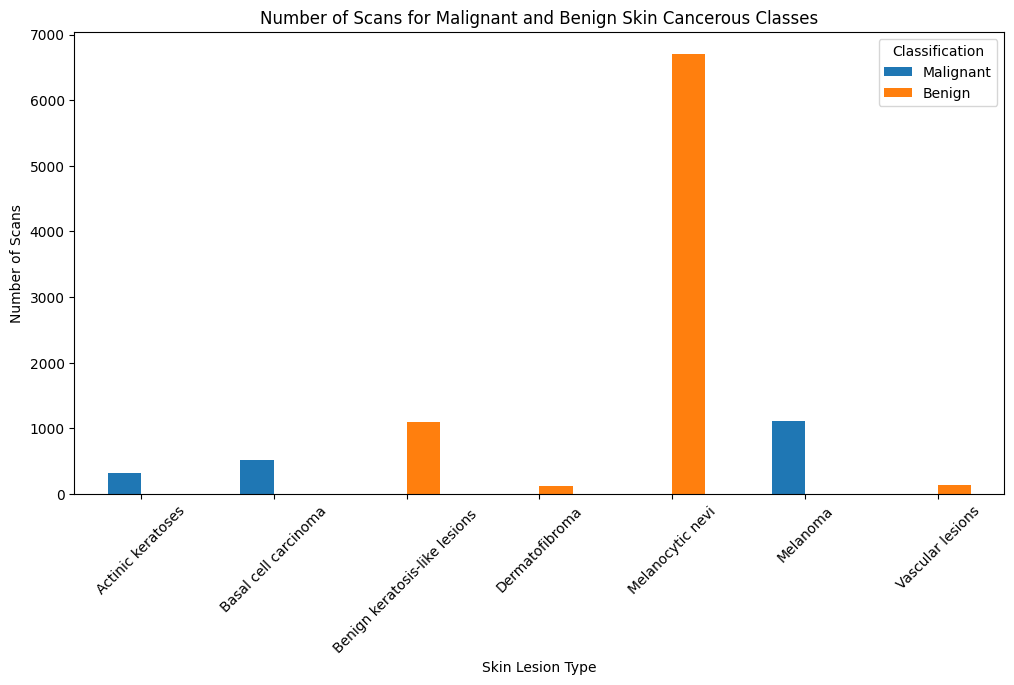

In [21]:
# Define labels
cancerous_labels = ['akiec', 'bcc', 'mel']  # Cancerous classes
non_cancerous_labels = ['bkl', 'df', 'nv', 'vasc']  # Non-cancerous classes

# Count the number of instances in each category
cancerous_counts = skin_df[skin_df['dx'].isin(cancerous_labels)]['dx'].map(lesion_type_dict).value_counts()
non_cancerous_counts = skin_df[skin_df['dx'].isin(non_cancerous_labels)]['dx'].map(lesion_type_dict).value_counts()

# Combine into a DataFrame for plotting
df_counts = pd.DataFrame({
    'Malignant': cancerous_counts,
    'Benign': non_cancerous_counts
}).fillna(0)

# Plotting
df_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Scans for Malignant and Benign Skin Cancerous Classes')
plt.xlabel('Skin Lesion Type')
plt.ylabel('Number of Scans')
plt.xticks(rotation=45)
plt.legend(title='Classification')
plt.show()

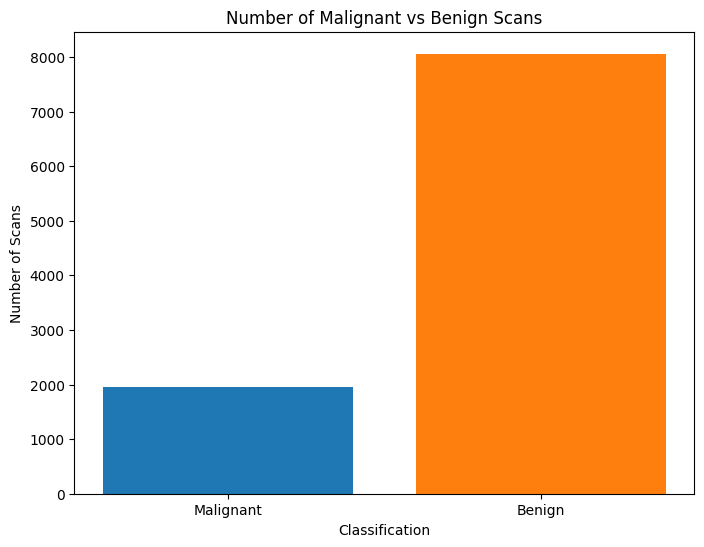

In [22]:
# Count the number of instances in each category
cancerous_count = skin_df[skin_df['dx'].isin(cancerous_labels)].shape[0]
non_cancerous_count = skin_df[skin_df['dx'].isin(non_cancerous_labels)].shape[0]

# Combine counts into a dictionary for plotting
counts = {'Malignant': cancerous_count, 'Benign': non_cancerous_count}

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(counts.keys(), counts.values(), color=['#1f77b4', '#ff7f0e'])
plt.title('Number of Malignant vs Benign Scans')
plt.xlabel('Classification')
plt.ylabel('Number of Scans')
plt.show()

# Hierarchial #3 (Various Cancers)

The various malignant skin cancer include melanoma, basal cell carcinoma, and squamous cell carcinoma.

In [23]:
cancerous_labels = ['akiec', 'bcc', 'mel']  # Cancerous classes

# Count the number of instances in each cancerous category
cancerous_counts = skin_df[skin_df['dx'].isin(cancerous_labels)]['dx'].map(lesion_type_dict).value_counts()

print(cancerous_counts)

Melanoma                1113
Basal cell carcinoma     514
Actinic keratoses        327
Name: dx, dtype: int64


KeyError: 'bkl'

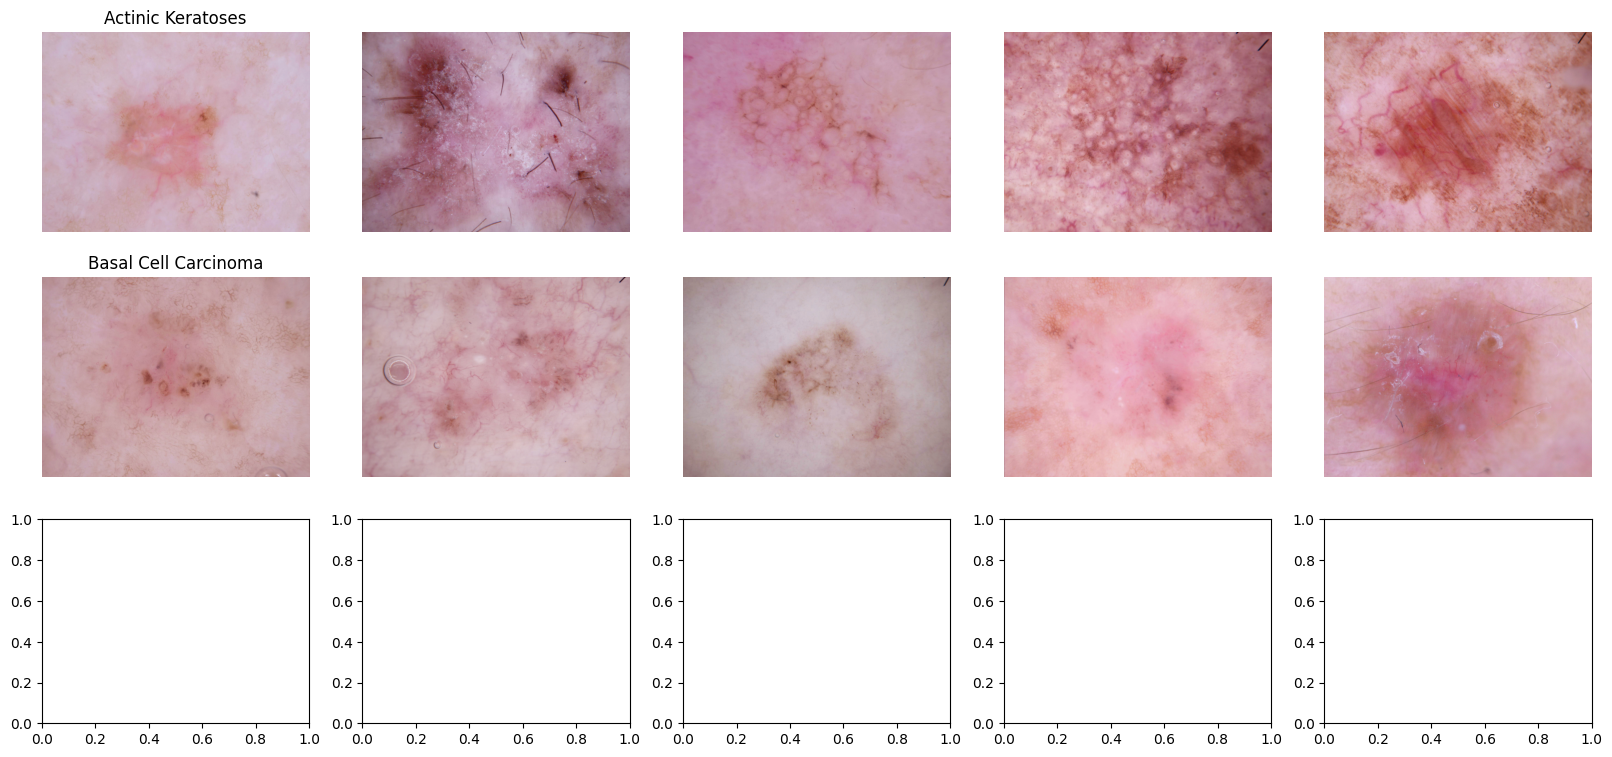

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you already have skin_df filtered to filtered_skin_df
cancerous_labels = ['akiec', 'bcc', 'mel']

# Mapping of abbreviations to full cell type names
lesion_type_dict = {
    'akiec': 'Actinic Keratoses',
    'bcc': 'Basal Cell Carcinoma',
    'mel': 'Melanoma'
}

filtered_skin_df = orig_skin_df

# Loading the images and adding to the DataFrame (assuming 'path' column contains image paths)
filtered_skin_df['image'] = filtered_skin_df['path'].map(lambda x: Image.open(x))

# Number of samples to display for each category
n_samples = 5

# Setting up the plot
fig, m_axs = plt.subplots(3, n_samples, figsize=(4 * n_samples, 3 * 3))  # 3 rows for the 3 cancerous classes

# Looping through each cell type and sampling n_samples images for display
for n_axs, (type_name, type_rows) in zip(m_axs, filtered_skin_df.sort_values(['dx']).groupby('dx')):
    full_type_name = lesion_type_dict[type_name]  # Get full name from the dictionary
    n_axs[0].set_title(full_type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Save the plot to a file
fig.savefig('category_samples.png', dpi=300)

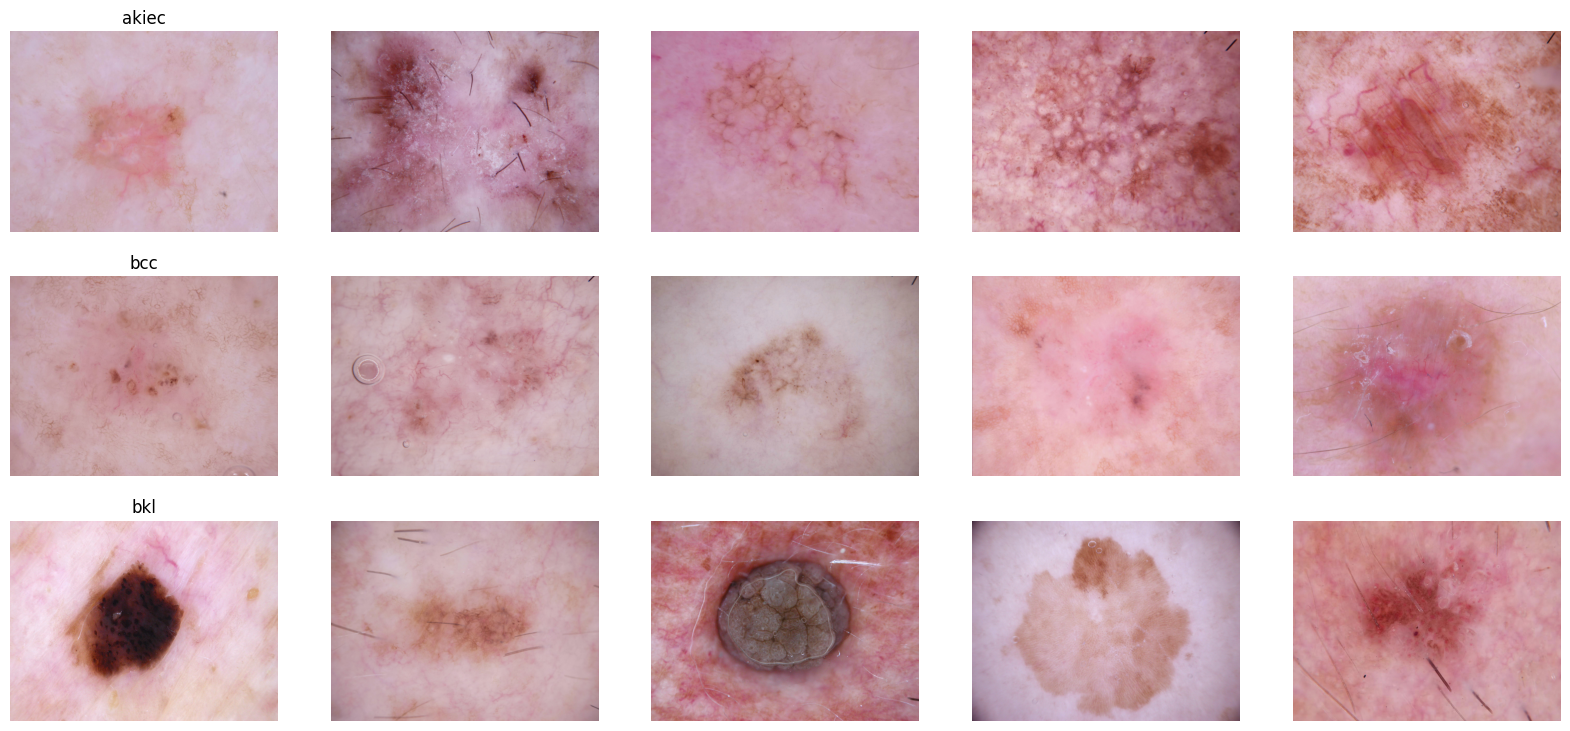

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you already have skin_df filtered to filtered_skin_df
cancerous_labels = ['akiec', 'bcc', 'mel']

filtered_skin_df = orig_skin_df
# Loading the images and adding to the DataFrame (assuming 'path' column contains image paths)
filtered_skin_df['image'] = filtered_skin_df['path'].map(lambda x: Image.open(x))

# Number of samples to display for each category
n_samples = 5

# Setting up the plot
fig, m_axs = plt.subplots(3, n_samples, figsize=(4 * n_samples, 3 * 3))  # 3 rows for the 3 cancerous classes

# Looping through each cell type and sampling n_samples images for display
for n_axs, (type_name, type_rows) in zip(m_axs, filtered_skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Save the plot to a file
fig.savefig('category_samples.png', dpi=300)

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
cancerous_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Number of Scans for Cancerous Classes')
plt.xlabel('Skin Lesion Type')
plt.ylabel('Number of Scans')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd

# Assuming skin_df is your original DataFrame
# Cancerous classes
cancerous_labels = ['akiec', 'bcc', 'mel']

# Filtering the DataFrame to include only rows with cancerous labels
filtered_skin_df = skin_df[skin_df['dx'].isin(cancerous_labels)]

# Display the first few rows of the filtered DataFrame
filtered_skin_df.head()